# NSGA2 Generator
This notebook demonstrates the use of the generator `NSGA2Generator` which implements the NSGA-II algorithm from [1]. We show how to set up the optimizer object, use it to solve a test problem, and show off some of the generator's output features. Running this notebook will generate files in a temporary directory on your computer. These files will be cleaned up at the end.

In [1]:
import json
import logging
import matplotlib.pyplot as plt
import os
import pandas as pd
import shutil
import tempfile

from xopt.generators.ga.nsga2 import NSGA2Generator, PolynomialMutation, SimulatedBinaryCrossover
from xopt.resources.test_functions.zdt import construct_zdt
from xopt import Xopt, Evaluator, VOCS

In [2]:
# The NSGA2Generator object emits logger messages
# Configure the logging module to output them to console
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',  # Format for log messages
    datefmt='%Y-%m-%d %H:%M:%S'  # Date/time format
)

In [3]:
# Get the problem ZDT2 and create an Xopt evaluator
prob_vocs, prob_fun, _ = construct_zdt(30, 3)
ev = Evaluator(function=prob_fun)

### Generator Setup and Use
First we create the `NSGA2Generator` object, demonstrate some of its settings, and then use it to solve the ZDT3 test problem.

In [4]:
# Create the NSGA2 generator with default settings
generator = NSGA2Generator(
    vocs=prob_vocs,  # Must provide the problem's details
)

# Let's demonstrate controlling the generator's hyperparameters and settings
generator = NSGA2Generator(
    vocs=prob_vocs,  # Must provide the problem's details
    population_size=50,  # How many individuals in a population
    mutation_operator=PolynomialMutation(pm=1/30, eta_m=20),  # Can manually specify mutation operator and hyperparameters
    crossover_operator=SimulatedBinaryCrossover(delta_1=0.5, delta_2=0.5, eta_c=20),  # Similarly can specify crossover manually
    deduplicate_output=True,  # Performs deduplication of candidate individuals. Ensure unique outputs from generator.
)

2025-03-03 00:02:33 - xopt.generator - INFO - Initialized generator nsga2
2025-03-03 00:02:33 - xopt.generator - INFO - Initialized generator nsga2


In [5]:
# Run the optimizer for a few generations. Notice log output printed below this cell
ev.max_workers = generator.population_size
X = Xopt(generator=generator, evaluator=ev, vocs=prob_vocs)

for _ in range(3):
    X.step()

2025-03-03 00:02:33 - xopt.base - INFO - Running Xopt step
2025-03-03 00:02:33 - xopt.generators.deduplicated - INFO - generated 50 candidates in 2.47ms (removed 0 duplicate individuals)
2025-03-03 00:02:33 - xopt.generators.ga.nsga2.NSGA2Generator.2597155252304 - INFO - adding 50 new evaluated individuals to generator
2025-03-03 00:02:33 - xopt.generators.ga.nsga2.NSGA2Generator.2597155252304 - INFO - completed generation 1 in 0.020s (n_feasible=0, n_err=0, children_performance=0.000s (0.000s), add_data_round=0, fevals=50, n_candidates=50)
2025-03-03 00:02:33 - xopt.base - INFO - Running Xopt step
2025-03-03 00:02:33 - xopt.generators.deduplicated - INFO - generated 50 candidates in 10.56ms (removed 0 duplicate individuals)
2025-03-03 00:02:33 - xopt.generators.ga.nsga2.NSGA2Generator.2597155252304 - INFO - adding 50 new evaluated individuals to generator
2025-03-03 00:02:33 - xopt.generators.ga.nsga2.NSGA2Generator.2597155252304 - INFO - completed generation 2 in 0.021s (n_feasible=0

### Exploring Optimizer Output
We now take a look at the metadata associated with the optimizer run as well as its output.

In [6]:
%%time
# Run for longer with log output turned off
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

for _ in range(47):
    X.step()

CPU times: total: 766 ms
Wall time: 902 ms


In [7]:
# Inspect generator properties
print(f"Saw {generator.fevals} function evaluations")  # Number of function evaluations returned to generator
print(f"Completed {generator.n_generations} generations")  # Number of generations finished
print(f"Generated {generator.n_candidates} candidate solutions")  # Number of individuals generated

Saw 2500 function evaluations
Completed 50 generations
Generated 2500 candidate solutions


In [8]:
# All evaluations are stored in the following Dataframe. Speific to this generator, a `xopt_parent_generation` and 
# `xopt_candidate_idx` columns which indicate from which generation the indvidual's parents belong to as well as providing a 
# unique index for indviduals.
# 
# NOTE: The data DataFrame is not stored when serializing the generator. It must be saved on its own for later use.
generator.data.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.020780,0.027708,0.684811,0.544403,0.961850,0.444892,0.587753,0.196877,0.281734,0.209661,...,0.026049,0.487175,0.761899,0,0,0.020780,4.276136,4.597861,0.000037,False
1,0.026699,0.885338,0.695941,0.139845,0.166562,0.892470,0.170315,0.164446,0.414868,0.788405,...,0.843158,0.962648,0.918821,0,21,0.026699,5.253110,5.661771,0.000013,False
2,0.030103,0.127207,0.117300,0.366545,0.210692,0.351275,0.304724,0.290119,0.701726,0.810971,...,0.317194,0.595671,0.603272,0,2,0.030103,4.699093,5.115936,0.000009,False
3,0.048478,0.501268,0.574121,0.095806,0.215357,0.863595,0.968498,0.417911,0.869840,0.431600,...,0.079452,0.966160,0.594885,0,17,0.048478,4.460538,5.001358,0.000008,False
4,0.056923,0.440067,0.343322,0.174968,0.001984,0.184308,0.701573,0.342111,0.187015,0.124871,...,0.184217,0.207212,0.981810,0,3,0.056923,4.007410,4.573208,0.000008,False


In [9]:
# Each population the optimizer has seen is stored by the unique indices of each individual.
print(generator.history_idx[-1][:16])  # Show the first few indices of last generation

# If you have the data DataFrame you can extract all variables, objectives, constraints for each population
# Get a DataFrame of all information for the first population with every row being an individual
generator.data[generator.data["xopt_candidate_idx"].isin(generator.history_idx[0])].head()

[2481, 2485, 2497, 2410, 2459, 2376, 2477, 2423, 2366, 2472, 2494, 2490, 2446, 2262, 2060, 2357]


,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.020780,0.027708,0.684811,0.544403,0.961850,0.444892,0.587753,0.196877,0.281734,0.209661,...,0.026049,0.487175,0.761899,0,0,0.020780,4.276136,4.597861,0.000037,False
1,0.026699,0.885338,0.695941,0.139845,0.166562,0.892470,0.170315,0.164446,0.414868,0.788405,...,0.843158,0.962648,0.918821,0,21,0.026699,5.253110,5.661771,0.000013,False
2,0.030103,0.127207,0.117300,0.366545,0.210692,0.351275,0.304724,0.290119,0.701726,0.810971,...,0.317194,0.595671,0.603272,0,2,0.030103,4.699093,5.115936,0.000009,False
3,0.048478,0.501268,0.574121,0.095806,0.215357,0.863595,0.968498,0.417911,0.869840,0.431600,...,0.079452,0.966160,0.594885,0,17,0.048478,4.460538,5.001358,0.000008,False
4,0.056923,0.440067,0.343322,0.174968,0.001984,0.184308,0.701573,0.342111,0.187015,0.124871,...,0.184217,0.207212,0.981810,0,3,0.056923,4.007410,4.573208,0.000008,False


Text(0.5, 1.0, 'ZDT3, Generation 50')

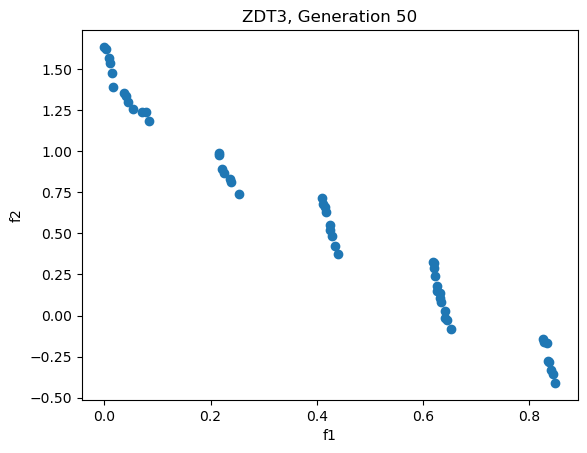

In [10]:
# Using the population records we can plot the final generation's objective functions
final_pop = generator.data[generator.data["xopt_candidate_idx"].isin(generator.history_idx[-1])]
plt.scatter(final_pop["f1"], final_pop["f2"])
plt.xlabel("f1")
plt.ylabel("f2")
plt.title(f"ZDT3, Generation {generator.n_generations}")

# File Output from Generator
In this section, we will take a look at the files which can be automatically written by the optimizer. We will create a temporary directory and clean it up at the end of this notebook.

The output files are the following.
 - `data.csv`: All data evaluated during the optimization
 - `vocs.txt`: The VOCS object so that the objectives, constraints, decision variables are retained alongside the data
 - `populations.csv`: Each population is written here with a column `xopt_generation` to distinguish which generation the row belongs to
 - `checkpoints`: This generator periodically saves its full state to timestamped files in this directory
 - `log.txt`: Log output from the generator is recorded to this file

 Wile running each of the blocks, go ahead and open the temporary directory printed from the next cell and take a look at the files for yourself.

In [11]:
# Setup our output directory
output_dir = tempfile.mkdtemp()
print(f"Will write data to \"{output_dir}\"")

Will write data to "C:\Users\chris\AppData\Local\Temp\tmp5um_pyix"


In [12]:
# Set up a generator configured to output data
generator = NSGA2Generator(
    vocs=prob_vocs,
    output_dir=output_dir,  # Where will we write data
    checkpoint_freq=8,  # Turn on checkpoints and set ow often (in terms of generations) we save the optimizer state
    log_level=logging.DEBUG,  # Set the level of log messages output to our log file
)

# Run it for a couple of generations
ev.max_workers = generator.population_size
X = Xopt(generator=generator, evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()

In [13]:
# Check out the generated files
print(f"\"{output_dir}\": {os.listdir(output_dir)}")
checkpoint_dir = os.path.join(output_dir, "checkpoints")
print(f"\"checkpoints\": {os.listdir(checkpoint_dir)}")

"C:\Users\chris\AppData\Local\Temp\tmp5um_pyix": ['checkpoints', 'data.csv', 'log.txt', 'populations.csv', 'vocs.txt']
"checkpoints": ['20250303_000234_1.txt', '20250303_000235_1.txt', '20250303_000235_2.txt', '20250303_000236_1.txt']


In [14]:
# In the event data was already written to `output_dir` the generator will choose a new path with a numeric suffix
# to avoid overwriting anything.
X = Xopt(generator=NSGA2Generator(vocs=prob_vocs, output_dir=output_dir), evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()

# Compare the requested path and where the data ended up
print(f"Requested path: \"{output_dir}\"")
print(f"Path used:      \"{X.generator.output_dir}\"")

# Clean up the directory
X.generator.close_log_file()
shutil.rmtree(X.generator.output_dir)

Requested path: "C:\Users\chris\AppData\Local\Temp\tmp5um_pyix"
Path used:      "C:\Users\chris\AppData\Local\Temp\tmp5um_pyix_2"


In [15]:
# Load all data back in
df = pd.read_csv(os.path.join(generator.output_dir, "data.csv"))
df.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.009403,0.202197,0.901480,0.613540,0.634626,0.521705,0.957340,0.175814,0.088735,0.508129,...,0.817043,0.105026,0.511149,0,1,0.009403,4.881326,5.103117,0.000028,False
1,0.026995,0.783383,0.690061,0.621846,0.120841,0.678955,0.709217,0.328045,0.554342,0.959793,...,0.126267,0.892470,0.273193,0,44,0.026995,5.551017,5.972806,0.000010,False
2,0.087032,0.728659,0.219598,0.456186,0.288097,0.444372,0.298574,0.399365,0.016537,0.121515,...,0.057726,0.970341,0.799651,0,9,0.087032,4.932082,5.668979,0.000009,False
3,0.094215,0.638083,0.069703,0.424460,0.001438,0.515158,0.681709,0.054810,0.475019,0.548532,...,0.686869,0.359134,0.441833,0,25,0.094215,3.899110,4.572490,0.000008,False
4,0.103015,0.125304,0.612343,0.831982,0.477802,0.566437,0.310895,0.185044,0.914365,0.706349,...,0.459297,0.826811,0.730320,0,13,0.103015,5.324193,6.107658,0.000008,False


In [16]:
# Read the VOCS object back in. This can be used for data analysis / restarting optimizations
with open(os.path.join(generator.output_dir, "vocs.txt")) as f:
    vocs_from_file = VOCS.from_dict(json.load(f))

# Show the objectives
vocs_from_file.objectives

{'f1': 'MINIMIZE', 'f2': 'MINIMIZE'}

In [17]:
# Load the populations and get just the last population
df = pd.read_csv(os.path.join(generator.output_dir, "populations.csv"))
last_pop = df[df["xopt_generation"] == df["xopt_generation"].max()]
last_pop.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error,xopt_generation
1550,0.848411,0.196903,0.031500,0.030233,0.013527,0.132858,0.085573,0.066693,0.048474,0.052090,...,0.108216,0.002341,31,1584,0.848411,-0.114703,2.052143,0.000007,False,32
1551,0.000001,0.095524,0.031696,0.006973,0.012753,0.078663,0.092874,0.014214,0.101098,0.031079,...,0.111413,0.073764,28,1430,0.000001,2.014241,2.015750,0.000029,False,32
1552,0.802237,0.221980,0.108830,0.048723,0.010757,0.057951,0.099335,0.061470,0.048733,0.017991,...,0.238382,0.072324,31,1594,0.802237,0.678978,2.002911,0.000008,False,32
1553,0.436124,0.279314,0.038123,0.036307,0.013610,0.057555,0.099105,0.060529,0.050508,0.055162,...,0.238687,0.072345,30,1519,0.436124,0.702721,2.041681,0.000008,False,32
1554,0.420096,0.260888,0.037436,0.030695,0.013534,0.057738,0.079585,0.009929,0.099419,0.017870,...,0.241582,0.006139,31,1552,0.420096,0.932482,2.125332,0.000007,False,32


In [18]:
# Reload the optimizer from its last checkpoint
# NOTE: the vocs object is not retained with the checkpoint and should be added as in the following code
last_checkpoint = os.path.join(checkpoint_dir, os.listdir(checkpoint_dir)[-1])
with open(last_checkpoint) as f:
    restored_generator = NSGA2Generator.from_dict({"vocs": prob_vocs, **json.load(f)})
print(f"From file: {restored_generator}")

# Demonstrate using the generator after loading (starting optimization from its last saved point)
X = Xopt(generator=restored_generator, evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()
print(f"Further optimization: {restored_generator}")

# Clean up the output
X.generator.close_log_file()
shutil.rmtree(X.generator.output_dir)

From file: NSGA2Generator(pop_size=50, crossover=SimulatedBinaryCrossover, mutation=PolynomialMutation, deduplicated=True, completed_gens=32, fevals=1600)
Further optimization: NSGA2Generator(pop_size=50, crossover=SimulatedBinaryCrossover, mutation=PolynomialMutation, deduplicated=True, completed_gens=64, fevals=3200)


In [19]:
# Clean up the original output
generator.close_log_file()
shutil.rmtree(output_dir)